In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm

import tensorflow as tf

config = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
session = tf.InteractiveSession(config=config)

In [2]:
# https://github.com/pymc-devs/pymc3/issues/804
# https://docs.pymc.io/advanced_theano.html#writing-custom-theano-ops
# http://deeplearning.net/software/theano/extending/extending_theano.html

import theano

def _to_tensor_type(shape):
    return theano.tensor.TensorType(dtype="float64",
                                    broadcastable=[False]*len(shape))


class TensorFlowOp(theano.Op):
    """A custom Theano Op uses TensorFlow as the computation engine
    
    Args:
        target (Tensor): The TensorFlow tensor defining the output of
            this operation
        parameters (list(Tensor)): A list of TensorFlow tensors that
            are inputs to this operation
        feed_dict (Optional(dict)): A "feed_dict" that is provided to
            the TensorFlow session when the operation is executed
        session (Optional): A TensorFlow session that can be used to
            evaluate the operation
    
    """
    def __init__(self, target, parameters, feed_dict=None, session=None):
        self.parameters = parameters
        self._feed_dict = dict() if feed_dict is None else feed_dict
        self._session = session
        self.target = target
        self.init_shapes()
        
        self.itypes = [_to_tensor_type(shape) for shape in self.shapes]
        self.otypes = [_to_tensor_type(self.output_shape)]
        
        self._grad_op = _TensorFlowGradOp(self)
    
    @property
    def session(self):
        if self._session is None:
            self._session = tf.get_default_session()
        return self._session

    def init_shapes(self):
        """
        Execute the operation once to determine the shapes of the tensors
        """
        self.grad_target = tf.gradients(self.target, self.parameters)
        in_values, out_value = self.session.run(
            [self.parameters, self.target], feed_dict=self._feed_dict)
        self.shapes = [np.shape(v) for v in in_values]
        self.output_shape = np.shape(out_value)

    def infer_shape(self, node, shapes):
        return self.output_shape,

    def perform(self, node, inputs, outputs):
        """Execute the operation using TensorFlow"""
        feed_dict = dict(zip(self.parameters, inputs), **self._feed_dict)
        outputs[0][0] = np.array(self.session.run(self.target, feed_dict=feed_dict))

    def grad(self, inputs, gradients):
        return self._grad_op(*(inputs + gradients))
    

class _TensorFlowGradOp(theano.Op):
    """A custom Theano Op defining the gradient of a TensorFlowOp
    
    Args:
        base_op (TensorFlowOp): The original Op
    
    """
    def __init__(self, base_op):
        self.base_op = base_op
        self.dy = tf.placeholder(tf.float64, base_op.output_shape)
        self.grad_target = tf.gradients(base_op.target,
                                        base_op.parameters,
                                        grad_ys=self.dy)
        types = [_to_tensor_type(shape) for shape in base_op.shapes]
        self.itypes = types + [_to_tensor_type(base_op.output_shape)]
        self.otypes = types

    def infer_shape(self, node, shapes):
        return self.base_op.shapes

    def perform(self, node, inputs, outputs):
        feed_dict = dict(zip(self.base_op.parameters, inputs[:-1]),
                         **self.base_op._feed_dict)
        feed_dict[self.dy] = inputs[-1]
        result = self.base_op.session.run(self.grad_target, feed_dict=feed_dict)
        for i, r in enumerate(result):
            outputs[i][0] = np.array(r)

In [3]:

# np.random.seed(1234)

# m = tf.Variable(0.5, dtype=tf.float64)
# b = tf.Variable(-0.1, dtype=tf.float64)
# log_s2 = tf.Variable(2*np.log(0.1), dtype=tf.float64)
# session.run(tf.global_variables_initializer())

# N = 10
# x = tf.constant(np.random.uniform(-3, 3, N))
# mu = m * x + b
# y_obs = mu.eval() + 0.5 * np.random.randn(N)

# log_prob = -0.5 * tf.reduce_sum(tf.square(y_obs - mu)) / tf.exp(log_s2)
# log_prob -= 0.5 * N * log_s2

# log_prob_op = TensorFlowOp(log_prob, [m, b, log_s2])

# with pm.Model() as model:
#     m_var = pm.Uniform("m", lower=-5, upper=5)
#     b_var = pm.Uniform("b", lower=-5, upper=5)
#     log_s2_var = pm.Uniform("log_s2", lower=-5, upper=5)
#     pm.Potential("log_prob", log_prob_op(m_var, b_var, log_s2_var))

#     trace = pm.sample(cores=1, tune=2000, draws=2000)

In [4]:
# plt.plot(x.eval(), y_obs, ".")

In [5]:
# import corner
# samples = np.vstack([trace[k] for k in ["m", "b", "log_s2"]]).T
# corner.corner(samples);

In [16]:
from exoplanet import kepler, transit, interp

# Typical Gaia density:
log_density_prior = -1.45, 0.35

dt = 1.0 / 24.0 / 60.0  # 1 minute cadence
# dt = 0.5 / 24.0  # 30 minute cadence
t = np.arange(0, 27.0, dt)
print(len(t))

T = tf.float64
np.random.seed(42)

G_grav = 2945.462538537765
factor = (G_grav / (3 * np.pi)) ** (1./3)

t_tensor = tf.constant(t, dtype=T)

# Star
flux = tf.Variable(0.0, dtype=T)
q = tf.Variable(0.5 + np.zeros(2), dtype=T)
log_rho_star = tf.Variable(log_density_prior[0], dtype=T)
rho_star = tf.exp(log_rho_star)

# Build the limb darkening model
q1 = q[0]
q2 = q[1]
c1 = 2.0 * tf.sqrt(q1) * q2
c2 = tf.sqrt(q1) * (1.0 - 2.0 * q2)
ld = transit.QuadraticLimbDarkening(c1, c2)

# Set up the planet parameters
n_pl = 2
p_samp = np.random.uniform(30.0, 60.0, 1)
t0_samp = np.random.uniform(t.min(), t.max(), 1)
r_samp = np.random.uniform(0.04, 0.1, 1)
b_samp = np.random.uniform(0, 1, 1)
e_samp = np.random.uniform(0, 0.5, 1)
omega_samp = np.random.randn(1, 2)
if n_pl > 1:
    p_samp = np.append(p_samp,
                       np.random.uniform(3, (t.max() - t.min())/5, n_pl-1))
    t0_samp = np.append(t0_samp, p_samp[1:] * np.random.rand(n_pl-1))
    r_samp = np.append(r_samp, np.random.uniform(0.04, 0.08, n_pl-1))
    b_samp = np.append(b_samp, np.random.uniform(0, 1, n_pl-1))
    e_samp = np.append(e_samp, np.random.uniform(0, 0.5, n_pl-1))
    omega_samp = np.concatenate((omega_samp, np.random.randn(n_pl-1, 2)), axis=0)

y_err = np.random.uniform(0.3, 0.9, len(t))
noise = y_err * np.random.randn(len(t))
    
log_period = tf.Variable(np.log(p_samp), dtype=T)
log_ror = tf.Variable(np.log(r_samp), dtype=T)
t0 = tf.Variable(t0_samp, dtype=T)
b = tf.Variable(b_samp, dtype=T)
e = tf.Variable(e_samp, dtype=T)
omega_vec = tf.Variable(omega_samp / np.sqrt(np.sum(omega_samp**2, axis=-1)), dtype=T)

omega_norm = tf.reduce_sum(tf.square(omega_vec), axis=-1)
omega = omega_vec / tf.expand_dims(tf.sqrt(omega_norm), -1)

period = tf.exp(log_period)
ror = tf.exp(log_ror)

# Compute the orbit model
a = factor * period**(2./3) * rho_star**(1./3)
cosi = tf.abs(b) / a
incl = tf.acos(cosi)

sin_omega = omega_vec[:, 0]
cos_omega = omega_vec[:, 1]
omega = tf.atan2(sin_omega, cos_omega)


coords = a[None, :, None] * kepler.sky_position(
    period[:, None],
    t0[:, None],
    e[:, None],
    omega[:, None],
    incl[:, None],
    t_tensor[None, :], tol=1e-5)

d = tf.sqrt(tf.reduce_sum(tf.square(coords[:2]), axis=0))
delta = transit.transit_depth(ld, d, ror[:, None]+tf.zeros_like(d), direction=coords[2], n_integrate=100)
light_curve = flux - 1e3*tf.reduce_sum(delta, axis=0)

session.run(tf.global_variables_initializer())

y_true = light_curve.eval()
y_obs = y_true + noise

y_tensor = tf.constant(y_obs, dtype=T)
y_err_tensor = tf.constant(y_err, dtype=T)

logprob = -0.5 * tf.reduce_sum(tf.square((y_tensor - light_curve) / y_err_tensor))

# Omega prior
# logprob -= 0.5 * tf.reduce_sum(omega_norm)

# Density prior
logprob -= 0.5 * tf.square((log_rho_star - log_density_prior[0]) / log_density_prior[1])

# Beta prior
alpha = 0.867
beta = 3.03
logprob += 2*tf.reduce_sum((alpha-1)*tf.log(e) + (beta-1)*tf.log(1-e))

params = [flux, q, log_rho_star, log_period, log_ror, t0, b, e, omega_vec]

38881


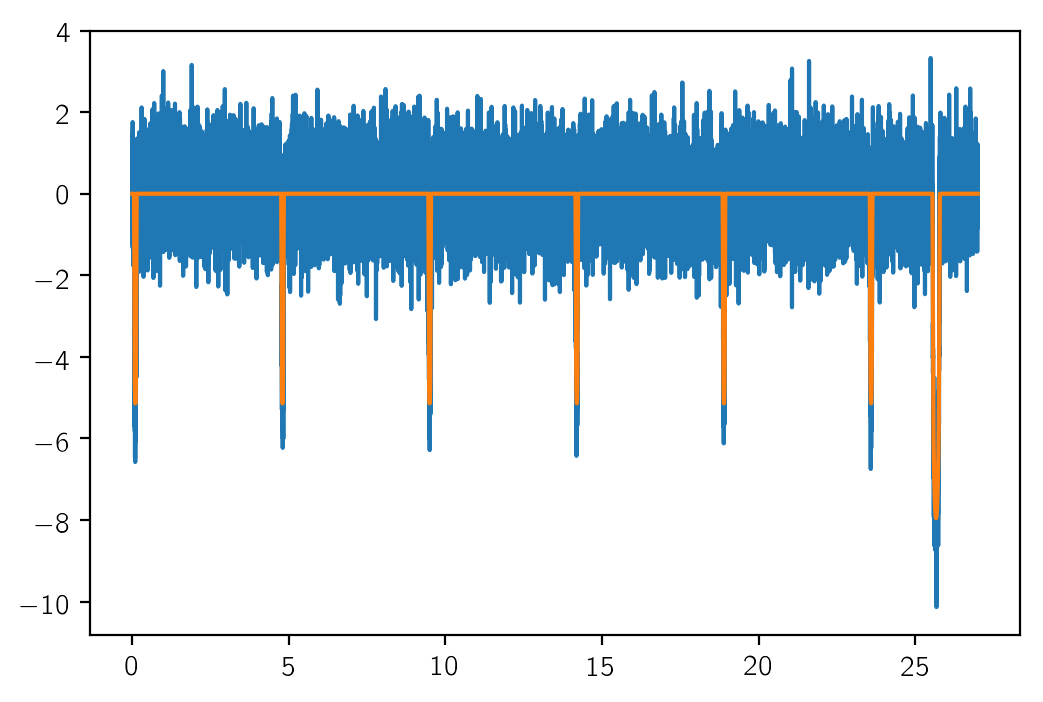

In [17]:
plt.plot(t, y_obs)
plt.plot(t, light_curve.eval())

In [18]:
log_prob_op = TensorFlowOp(logprob, params)

with pm.Model() as model:
    flux_var = pm.Uniform("flux", lower=-5, upper=5)
    q_var = pm.Uniform("q", shape=(2,), lower=0, upper=1)
    log_rho_star_var = pm.Uniform("logrhostar", lower=-5, upper=5)
    log_period_var = pm.Uniform("logperiod", shape=(n_pl,), lower=np.log(3), upper=np.log(5000))
    t0_var = pm.Uniform("t0", shape=(n_pl,), lower=0, upper=t.max()-t.min())
    log_ror_var = pm.Uniform("logror", shape=(n_pl,), lower=np.log(0.01), upper=np.log(0.2))
    b_var = pm.Uniform("b", shape=(n_pl,), lower=0, upper=2)
    e_var = pm.Uniform("e", shape=(n_pl,), lower=0, upper=1)
    omega_var = pm.Normal("omega", shape=(n_pl, 2))

    start = {
        "flux": flux.eval(),
        "q": q.eval(),
        "logrhostar": log_rho_star.eval(),
        "logperiod": log_period.eval(),
        "t0": t0.eval(),
        "logror": log_ror.eval(),
        "b": b.eval(),
        "e": e.eval(),
        "omega": omega_vec.eval(),
    }
    
    lp = log_prob_op(flux_var, q_var, log_rho_star_var, log_period_var,
                     log_ror_var, t0_var, b_var, e_var, omega_var)
    pm.Potential("log_prob", lp)

    map_val = pm.find_MAP(start=start)
    map_val = pm.find_MAP(start=start)
    map_val = pm.find_MAP(start=start)
    trace = pm.sample(cores=1, chains=1, tune=1000, draws=1000, start=map_val)

logp = -19,488, ||grad|| = 32.837: 100%|██████████| 172/172 [00:08<00:00, 21.47it/s] 
logp = -19,488, ||grad|| = 58.978: 100%|██████████| 199/199 [00:09<00:00, 21.43it/s] 
logp = -19,490, ||grad|| = 234: 100%|██████████| 65/65 [00:03<00:00, 21.63it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [omega, e, b, logror, t0, logperiod, logrhostar, q, flux]
  1%|          | 11/2000 [01:00<3:50:56,  6.97s/it]/Users/dforeman/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


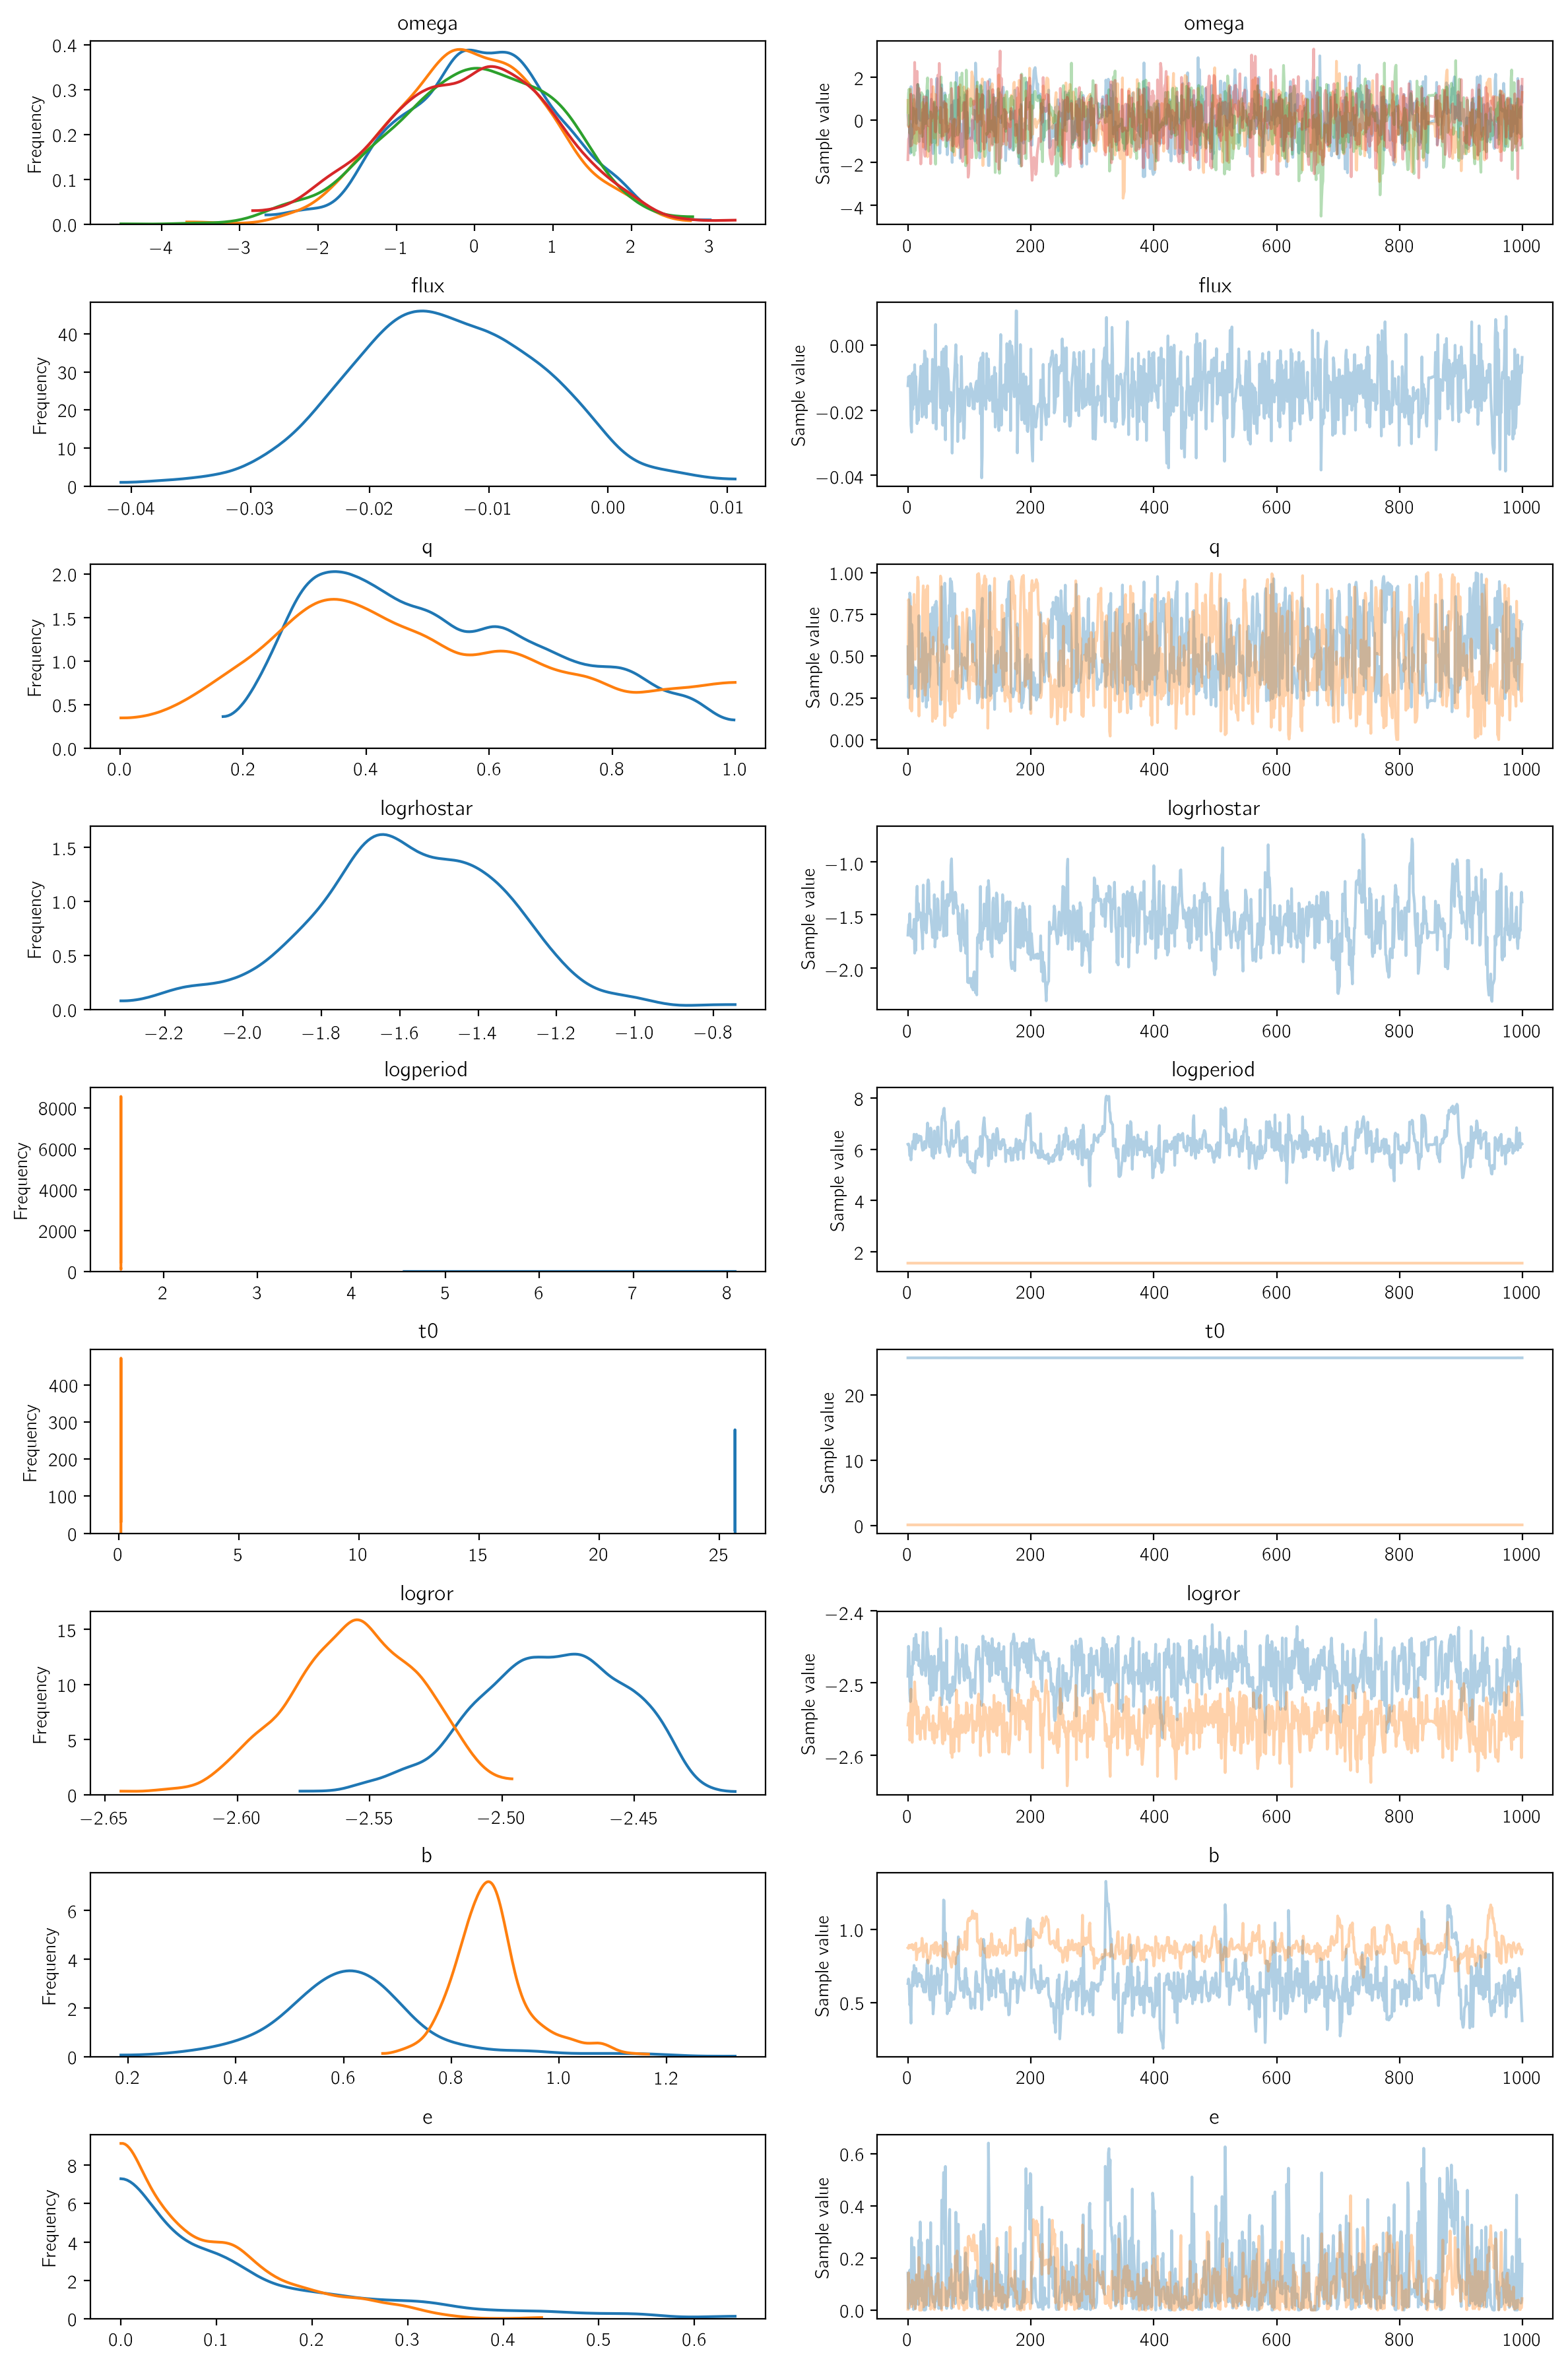

In [11]:
pm.traceplot(trace);

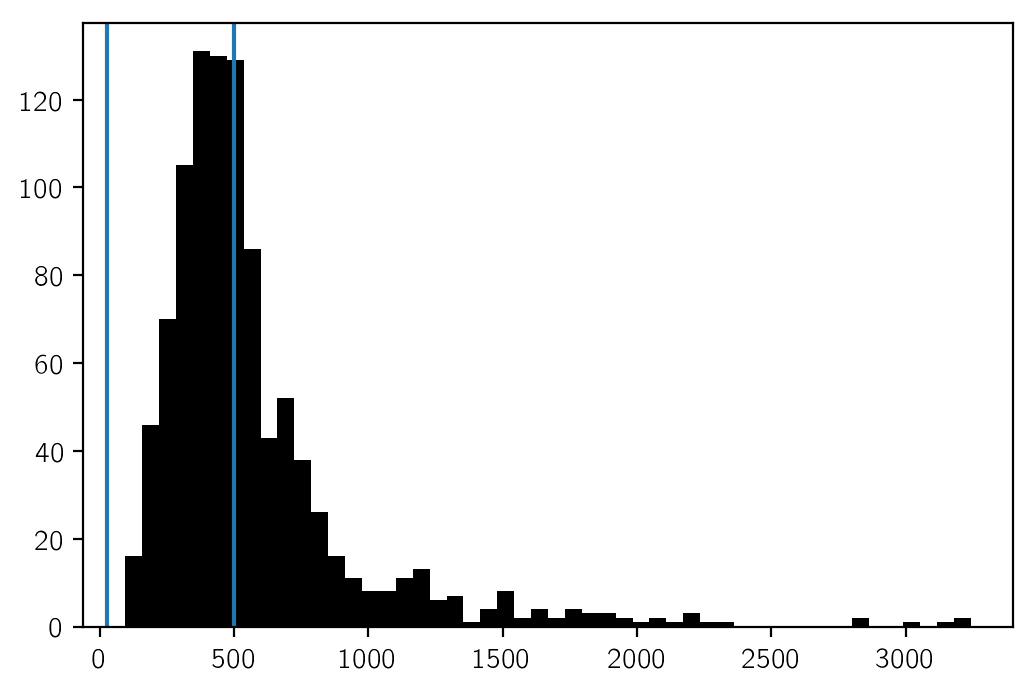

In [12]:
plt.hist(np.exp(trace["logperiod"][:, 0]), 50, color="k")
plt.axvline(p_samp[0])
plt.axvline(t.max() - t.min());

In [15]:
q = np.percentile(np.exp(trace["logperiod"][:, 0]), [16, 50, 84])
q[1], np.diff(q)

(474.46357808174344, array([173.53558387, 304.53973613]))

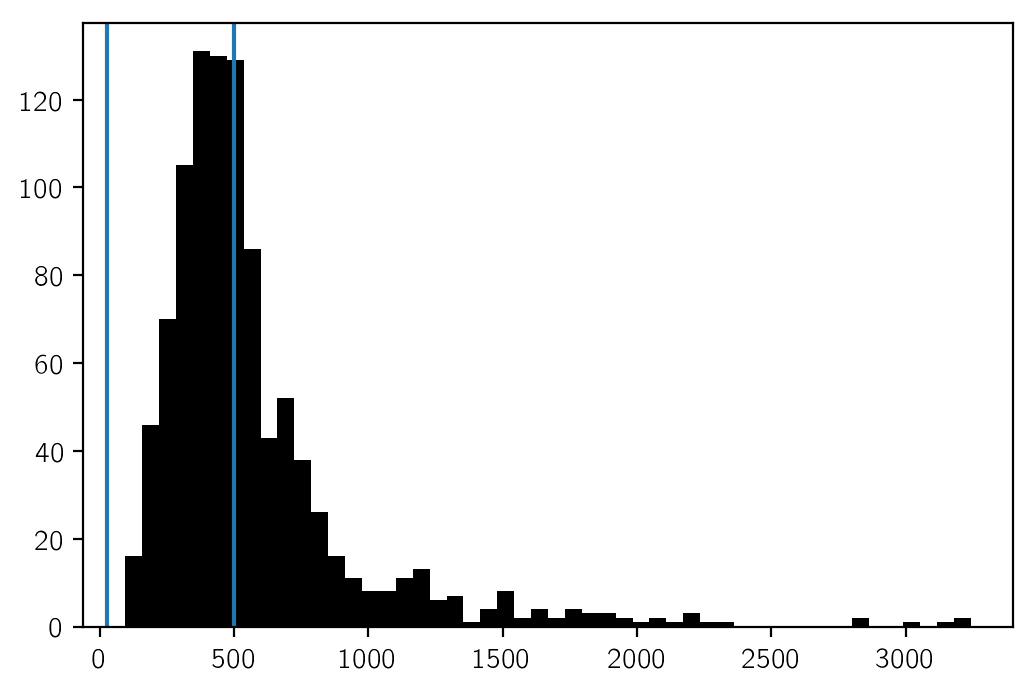

In [13]:
plt.hist(np.exp(trace["logperiod"][:, 0]), 50, color="k")
plt.axvline(p_samp[0])
plt.axvline(t.max() - t.min());

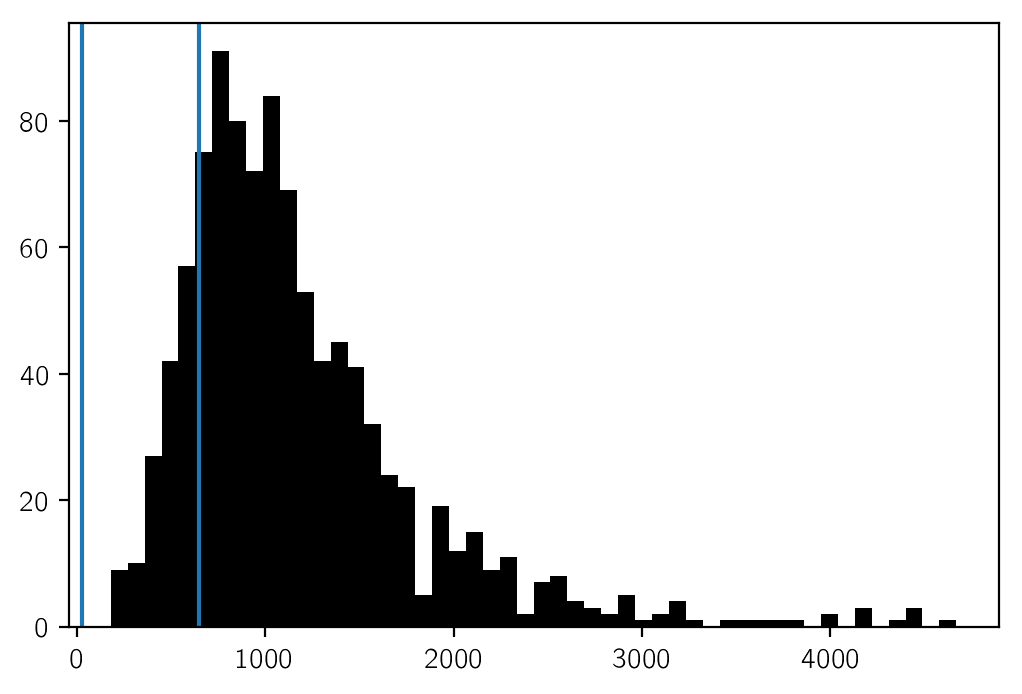

In [54]:
plt.hist(np.exp(trace["logperiod"][:, 0]), 50, color="k")
plt.axvline(p_samp[0])
plt.axvline(t.max() - t.min());